In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
from collections import namedtuple
from pathlib import Path
import matplotlib.gridspec as gridspec
import signal_process
import matplotlib as mpl
from plotUtil import Colormap
import scipy.signal as sg
import warnings

cmap = matplotlib.cm.get_cmap("hot_r")
warnings.simplefilter(action="default")

from callfunc import processData

#%% Subjects
basePath = [
    "/data/Clustering/SleepDeprivation/RatJ/Day1/",
    "/data/Clustering/SleepDeprivation/RatK/Day1/",
    "/data/Clustering/SleepDeprivation/RatN/Day1/",
    "/data/Clustering/SleepDeprivation/RatJ/Day2/",
    "/data/Clustering/SleepDeprivation/RatK/Day2/",
    "/data/Clustering/SleepDeprivation/RatN/Day2/",
    # "/data/Clustering/SleepDeprivation/RatK/Day4/"
]


sessions = [processData(_) for _ in basePath]

/home/bapung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bapung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bapung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bapung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Bicoherence analysis on ripples

In [ ]:
colmap = Colormap().dynamicMap()

for sub, sess in enumerate(sessions):

    sess.trange = np.array([])
    eegSrate = sess.recinfo.lfpSrate
    ripples = sess.ripple.time
    lfp = sess.spindle.best_chan_lfp()[0]

    lfpripple = []
    for ripple in ripples:
        start = int(ripple[0] * eegSrate)
        end = int(ripple[1] * eegSrate)
        lfpripple.extend(lfp[start:end])

    lfpripple = np.asarray(lfpripple)
    bicoh, freq, bispec = signal_process.bicoherence(lfpripple, fhigh=300)

    bicohsmth = gaussian_filter(bicoh, sigma=3)
    # bicoh = np.where(bicoh > 0.05, bicoh, 0)
    plt.clf()
    fig = plt.figure(1, figsize=(10, 15))
    gs = gridspec.GridSpec(1, 2, figure=fig)
    fig.subplots_adjust(hspace=0.3)
    ax = fig.add_subplot(gs[0, 1])
    ax.clear()
    im = ax.pcolorfast(
        freq, freq, np.sqrt(bicohsmth), cmap=colmap, vmax=0.5, vmin=0.018
    )
    # ax.contour(freq, freq, bicoh, levels=[0.1, 0.2, 0.3], colors="k", linewidths=1)
    ax.set_ylim([1, max(freq) / 2])
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Frequency (Hz)")
    # cax = fig.add_axes([0.3, 0.8, 0.5, 0.05])
    # cax.clear()

    # ax.contour(freq, freq, bicoh, levels=[0.1, 0.2, 0.3], colors="k", linewidths=1)
    fig.colorbar(im, ax=ax, orientation="horizontal")

### Gamma across SD

In [ ]:
group = []
plt.clf()
fig = plt.figure(1, figsize=(10, 15))
gs = gridspec.GridSpec(1, 3, figure=fig)
fig.subplots_adjust(hspace=0.3)
for sub, sess in enumerate(sessions[:3]):

    sess.trange = np.array([])
    lfp = sess.spindle.best_chan_lfp()[0]
    post = sess.epochs.post
    sd_period = [post[0], post[0] + 5 * 3600]
    t = np.linspace(0, len(lfp) / eegSrate, len(lfp))

    lfpsd = lfp[(t > sd_period[0]) & (t < sd_period[1])]
    tsd = np.linspace(sd_period[0], sd_period[1], len(lfpsd))
    binsd = np.linspace(sd_period[0], sd_period[1], 6)

    specgram = signal_process.spectrogramBands(lfpsd)

    gamma = stats.zscore(specgram.gamma)
    first_hour_gamma = gamma[(specgram.time > 0) & (specgram.time < 3600)]
    last_hour_gamma = gamma[(specgram.time > 4 * 3600) & (specgram.time < 5 * 3600)]

    hist_first, _ = np.histogram(first_hour_gamma, bins=np.arange(-3, 3, 0.1))
    hist_last, edge = np.histogram(last_hour_gamma, bins=np.arange(-3, 3, 0.1))

    ax = fig.add_subplot(gs[sub])
    ax.plot(edge[:-1], hist_first, "k", label="1st hour")
    ax.plot(edge[:-1], hist_last, "r", label="5th hour")
    ax.set_yscale("log")
    ax.set_xlabel("zscored values")
    ax.set_ylabel("Counts")
    ax.legend()

### PSD during sleep deprivation from first to last hour to observe gamma reduction

IndexError: index 3 is out of bounds for GridSpec with size 3

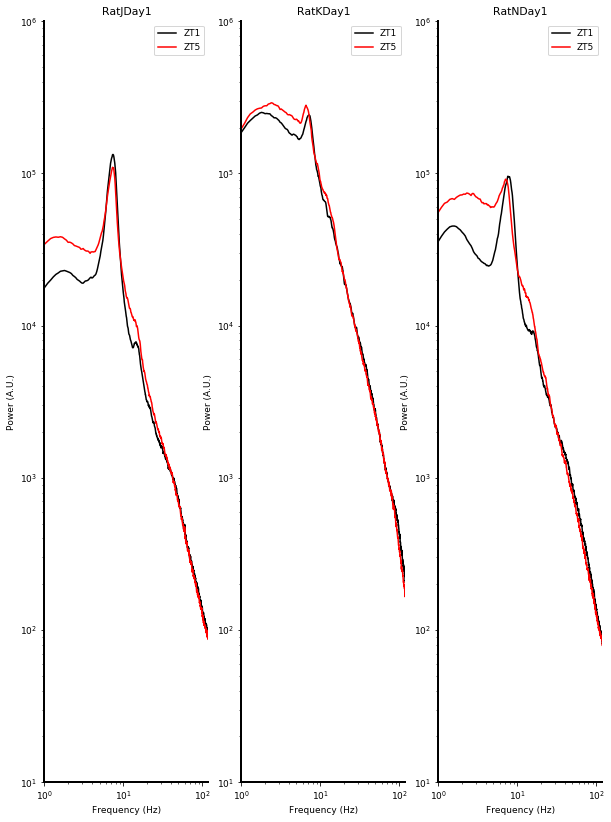

In [4]:
plt.clf()
fig = plt.figure(1, figsize=(10, 15))
gs = gridspec.GridSpec(1, 3, figure=fig)
fig.subplots_adjust(hspace=0.3)

for sub, sess in enumerate(sessions):
    sess.trange = np.array([])
    eegSrate = sess.recinfo.lfpSrate
    channel = sess.theta.bestchan
    post = sess.epochs.post
    eeg = sess.utils.geteeg(chans=channel, timeRange=[post[0], post[0] + 5 * 3600])
    nfrms_hour = eegSrate * 3600
    lfp1st = eeg[:nfrms_hour]
    lfp5th = eeg[-nfrms_hour:]

    psd = lambda sig: sg.welch(
        sig, fs=eegSrate, nperseg=10 * eegSate, noverlap=5 * eegSrate
    )
    multitaper = lambda sig: signal_process.mtspect(
        sig, fs=eegSrate, nperseg=10 * eegSrate, noverlap=5 * eegSrate
    )

    _, psd1st = multitaper(lfp1st)
    f, psd5th = multitaper(lfp5th)

    ax = fig.add_subplot(gs[sub])
    ax.loglog(f, psd1st, "k", label="ZT1")
    ax.loglog(f, psd5th, "r", label="ZT5")
    ax.set_xlim([1, 120])
    ax.set_ylim([10, 10e5])
    ax.set_title(sess.sessinfo.session.sessionName)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power (A.U.)")
    ax.legend()


### Plot spectrogram for different frequency bands (gamma, ripple) separately

In [ ]:
plt.clf()
fig = plt.figure(1, figsize=(10, 15))
gs = gridspec.GridSpec(2, 3, figure=fig)
fig.subplots_adjust(hspace=0.3)
for sub, sess in enumerate(sessions[:3]):
    sess.trange = np.array([])
    post = sess.epochs.post
    sd_period = [post[0], post[0] + 5 * 3600]
    thetachan = sess.theta.bestchan
    lfpsd = sess.utils.geteeg(chans=thetachan, timeRange=sd_period)
    specgram = signal_process.spectrogramBands(lfpsd, window=4, overlap=2)
    sxx = specgram.sxx
    freq = specgram.freq
    gamma = sxx[np.where((freq > 30) & (freq < 90))[0], :]
    ripple = sxx[np.where((freq > 150) & (freq < 250))[0], :]

    ax = fig.add_subplot(gs[0, sub])
    ax.imshow(gamma, aspect="auto")

    ax = fig.add_subplot(gs[1, sub])
    ax.imshow(ripple, aspect="auto")

### Ripple rate in recovery sleep compared to last hour of sleep deprivation

In [ ]:
plt.clf()
fig = plt.figure(1, figsize=(10, 15))
gs = gridspec.GridSpec(1, 2, figure=fig)
fig.subplots_adjust(hspace=0.3)

rplrt, nrem_dur = [], []
for sub, sess in enumerate(sessions):
    sess.trange = np.array([])
    states = sess.brainstates.states
    ripples = sess.ripple.time
    post = sess.epochs.post
    states_recvslp = states.loc[
        (states.name == "nrem") & (states.start > post[0] + 5 * 3600)
    ].copy()
    nrem_bins = np.asarray(states_recvslp[["start", "end"]]).ravel()
    nrpls = np.histogram(ripples, bins=nrem_bins)[0][::2]
    rpl_rate = nrpls / np.diff(nrem_bins)[::2]

    nrem_dur.append(np.sum(np.diff(nrem_bins)[::2]))
    rplrt.append(rpl_rate)


ax = fig.add_subplot(gs[0])

for i in range(3):
    rplrt_sd_mean = [np.mean(rplrt[_]) for _ in [i, i + 3]]
    rplrt_sd_std = [np.std(rplrt[_]) / np.sqrt(len(rplrt[_])) for _ in [i, i + 3]]
    ax.errorbar([1, 2], rplrt_sd_mean, yerr=rplrt_sd_std, color="gray")


ax.set_xticks([1, 2])
ax.set_xticklabels(["SD", "NSD"])
ax.set_xlim([0, 3])
ax.set_ylim([0.3, 1.2])
ax.set_ylabel("Ripple rate (Hz)")
ax.set_title("Mean ripple rate compared between \n recovery sleep and control session")


ax = fig.add_subplot(gs[1])
ax.bar([1, 2], [np.mean(nrem_dur[:3]), np.mean(nrem_dur[3:])], color="gray", width=0.6)
ax.set_xticks([1, 2])
ax.set_xticklabels(["SD", "NSD"])
ax.set_xlim([0, 3])
ax.set_ylabel("Duration (s)")
ax.set_title("Total NREM duration")
# ax.errorbar([1, 2], [np.mean(nrem_dur[:3]), np.mean(nrem_dur[3:])])

### Hswa-Ripple locking